<img src="../../img/backdrop-wh.png" alt="Drawing" style="width: 300px;"/>

# TF-IDF

* * * 

<div class="alert alert-success">  
    
### Learning Objectives 
    
* Understand the TF-IDF algorithm, and how it's used in information retrieval.
* Understand the difference between TF-IDF and simple word counts.
* Use Scikit Learn to extract TF-IDF scores from our text data.
* Use TF-IDF scores to compare posts.
</div>

### Icons Used in This Notebook
🔔 **Question**: A quick question to help you understand what's going on.<br>
💡 **Tip**: How to do something a bit more efficiently or effectively.<br>
⚠️ **Warning:** Heads-up about tricky stuff or common mistakes.<br>
💭 **Reflection**: Reflecting on ethical implications, biases, and social impact in data science.<br>

### Sections
1. [Turning Words into Numbers](#words)
2. [Bag-Of-Words Representation](#bow)
3. [Testing TF-IDF with a toy dataset](#toy)
4. [Using TF-IDF on Reddit datasets](#reddit)
5. [Using TF-IDF to Find Similar Posts](#similar)

<a id='words'></a>

# Turning Words Into Numbers

In the previous notebook, we covered methods to clean and tokenize text into units (like words, bigrams, and trigrams).

For many data science applications, we need a way to convert the content of a text (the list of tokens) into useful numbers that can be used as the features of a model or analysis. One way to do this is to to use a method called Term Frequency-Inverse Document Frequency (TF-IDF). 

Even today, TF-IDF is:
- Used under the hood in many search engines and recommender systems;
- A baseline for evaluating more complex models like word embeddings and transformers;
- A great tool for small or interpretable projects where LLMs are overkill;

Note that turning words into numbers, ultimately, is a question of **representation**. A text representation is easier for humans to understand, but a numerical representation is easier to perform large scale computational analysis on. The more we change the representation, the more distant our reading of the text becomes. We may gain some benefits from this, but we must also keep in mind what we lose.

## Retrieving the Dataset


### Note on package installation

- If you are running this notebook on **DataHub**, you may need to **uncomment and run** the `%pip install ...` line below if you get an error about a missing package. Restart your kernel after running this cell!
- If you are working **locally** (on your own computer), you should already have all required packages installed via your Conda environment (see the ***"Local Python and Jupyter Setup"*** page on bCourses). Only use the `pip install` line if you see an ImportError and know what you’re doing.

In [1]:
#%pip install scikit-learn gdown

In [2]:
import gdown

gdown.download("https://drive.google.com/uc?id=1Glac4spXraWRcC_loxu1Cu4Bw-szS2ou", "../../data/aita_pp.csv", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1Glac4spXraWRcC_loxu1Cu4Bw-szS2ou
To: /Users/tomvannuenen/Library/CloudStorage/Dropbox/GitHub/DEV/DIGHUM160/data/aita_pp.csv
100%|██████████████████████████████████████| 56.6M/56.6M [00:02<00:00, 26.5MB/s]


'../../data/aita_pp.csv'

In [3]:
import os
import pandas as pd

In [4]:
df = pd.read_csv('../../data/aita_pp.csv')

**Use the `2_TF_IDF_Project.ipynb` notebook to run the TF-IDF operations explained in this notebook on your own data.**

<a id='bow'></a>

# Bag-Of-Words Representation

Before we do TF-IDF, we need to learn something about **bag-of-words (BOW)** models.

The idea of BOW models is to encode the corpus in terms of word frequencies. In a bag-of-words, we taken some text, tokenize it, and then tabulate the frequencies of each token. The numerical representation of the text, then, is a vector indicating the frequencies of each token for that text.

For example, if we're considering a Reddit post on r/amitheasshole: 

<img src="../../img/bow.svg"  width="600" height="300">


We take each token from the review, "toss it in a bag", and count up the frequencies of each word. The numerical representation, then, is the vector on the right: the number of appearances of each token. The "bag" here denotes that we are not modeling structure within the text - only the frequencies of the words.


### Document Term Matrix

In most text corpora, we will have many samples or *documents*. For example, in our Reddit dataset, we have many posts. Each post stands on its own as a unique sample: it can be thought of as a unique document in the entire *corpus*. 

Since they are all related to each other, many tokens might be shared across posts. So, when creating the bag-of-words model, we can tokenize across all documents, forming a *vocabulary*. Then, we can represent a single document by which of the tokens in the vocabulary are represented, and their frequency within the document.

If the vocabulary has $V$ tokens, then each document will be encoded in a $V$-dimensional vector. If there are $D$ documents, the entire dataset can be represented in a $D \times V$ matrix, where each row corresponds to the document, and each column corresponds to the token (or "term"). This $D \times V$ matrix is a **document term matrix** (DTM).

Let's consider a simple example. Suppose we have the "documents":

```
["You are at a workshop. Are you ready?",
 "Welcome to Berkeley!",
 "I am teaching a workshop."]
```

The unique (word) tokens in this "corpus", in alphabetical order, are:

```
[a, am, are, at, berkeley, i, ready, teaching, to, welcome, workshop, you]
```

The DTM can be formed by going through each document, ticking off the frequency of each token in each document, and plugging this number into the matrix:

$$
\begin{array}{c|cccccccccccc}
 & \text{a} & \text{am} & \text{are} & \text{at} & \text{berkeley} & \text{i} & \text{ready} & \text{teaching} & \text{to} & \text{welcome} & \text{workshop} & \text{you} \\\hline
\text{Document 1} & 1 & 0 & 2 & 1 & 0 & 0 & 1 & 0 & 0 & 0 & 1 & 1 \\
\text{Document 2} & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 1 & 1 & 0 & 0 \\
\text{Document 3} & 1 & 1 & 0 & 0 & 0 & 1 & 0 & 1 & 0 & 0 & 1 & 0 \\
\end{array}
$$

The numerical representation for each document is a row in the matrix. For example, Document 1 has numerical representation $[1, 0, 2, 1, 0, 0, 1, 0, 0, 0, 1, 1]$.

To create a DTM, we will use the `CountVectorizer` from the package `sklearn`, a heavily used machine learning package.

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

Here is the workflow:

1. We first create a `CountVectorizer` object, and choose specific settings for how we'll go about creating the DTM. Check out the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to see what options are available.
2. Then, we "fit" this `CountVectorizer` object to the data. In this context, "fitting" consists of establishing a vocabulary of tokens from the documents in your dataset.
3. Finally, we "transform" the data according to the "fitted" `CountVectorizer` object. This means taking our text data and transforming it into a DTM according to the vocabulary established by the "fitting" step.
4. You can do steps 2 and 3 in one fell swoop using a `fit_transform` function.


In [6]:
corpus = [
  'My cat has paws.',
  'Can we let the dog out?',
  'Our dog really likes the cat but the cat does not agree.']
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
test_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
test_df

,agree,but,can,cat,does,dog,has,let,likes,my,not,our,out,paws,really,the,we
0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0
1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,1
2,1,1,0,2,1,1,0,0,1,0,1,1,0,0,1,2,0


Each column in the matrix represents a unique word in the vocabulary, while each row represents the document in our dataset. In this case, we have three sentences (i.e. the document), and therefore we three rows. The values in each cell are the word counts. Note that with this representation, counts of some words could be 0 if the word did not appear in the corresponding document. 


🔔 **Question**: Lets look at the shape of the matrix. How many unique words are there in the matrix?'

In [7]:
X.shape

(3, 17)

Now, we have numbers representing the contents of the documents! Matrices like this are the simplest way to represent texts. However, it biases most frequent words and ends up ignoring rare words which could have helped is in processing our data more efficiently.

Often, we not only want to focus on the frequency of words present in the corpus but also want to know the importance of the words. This is where TF-IDF (term frequency-inverse document frequency) comes in.

# Implementing TF-IDF

TF-IDF, short for **term frequency–inverse document frequency**, is a metric that reflects how important a word is to a **document** in a collection or **corpus**. When talking about text datasets, the dataset is called a corpus, and each datapoint is a document. A document can be a post, a paragraph, a webpage, whatever is considered the individual unit of text for a given datset. A **term** is each unique token in a document (we previously also referred to this as **type**). 

For example in a corpus of sentences, a document might be: `"I went to New York City in New York state."` 

The processed tokens in that document might be: `[went, new_york, city, new_york, state]`.

The document would have four unique terms: `[went, new_york, city, state]`.

The TF-IDF value increases proportionally to the number of times a word appears in the document (the term frequency, or TF), and is offset by the number of documents in the corpus that contain the word (the inverse document frequency, or IDF). This helps to adjust for the fact that some words appear more frequently in general – such as articles and prepositions.

We won't go into much detail about the math behind calculating the TF-IDF (see the D-Lab Text Analysis workshop videos to see more). The key components to remember are:

1. There is one TF-IDF score per unique word and unique document.
2. A high TF-IDF score suggests that word is descriptive of that document.
3. A low TF-IDF score may be because either the word is not frequent in that document, or that it is frequent in many documents in the dataset - either way, it may not be a good descriptor of that document.

The intuition is that if a word occurs many times in one post but rarely in the rest of the corpus, it is probably useful for characterizing that post; conversely, if a word occurs frequently in a post but also occurs frequently in the corpus, it is probably less characteristic of that post.

⚠️ **Warning:**  Word order is still not retained in this type of featurization, since all that is counted is overall frequency of a word in a document. So it is still a **bag-of-words** approach.

<a id='toy'></a>

# Testing TF-IDF with a Toy Dataset

Let's try TF-IDF out with a toy dataset. Here we have three documents about Python, but with different meanings. If we are trying to distinguish between these documents, the word "Python" would not be very useful, since it occurs in all of the documents, but other terms might, like "Monty", "snake", etc.

In [8]:
document1 = """Python is a 2000 made-for-TV horror movie directed by Richard
Clabaugh. The film features several cult favorite actors, including William
Zabka of The Karate Kid fame, Wil Wheaton, Casper Van Dien, Jenny McCarthy,
Keith Coogan, Robert Englund (best known for his role as Freddy Krueger in the
A Nightmare on Elm Street series of films), Dana Barron, David Bowe, and Sean
Whalen."""

document2 = """Python, from the Greek word (πύθων/πύθωνας), is a genus of
nonvenomous pythons[2] found in Africa and Asia. Currently, 7 species are
recognised.[2] A member of this genus, P. reticulatus, is among the longest
snakes known."""

document3 = """Monty Python (also collectively known as the Pythons) are a British 
surreal comedy group who created the sketch comedy television show Monty Python's 
Flying Circus, which first aired on the BBC in 1969. Forty-five episodes were made 
over four series."""

document4 = """Python is an interpreted, high-level, general-purpose programming language. 
Created by Guido van Rossum and first released in 1991, Python's design philosophy emphasizes 
code readability with its notable use of significant whitespace. Its language constructs and 
object-oriented approach aim to help programmers write clear, logical code for small and 
large-scale projects."""

document5 = """The Colt Python is a .357 Magnum caliber revolver formerly
manufactured by Colt's Manufacturing Company of Hartford, Connecticut.
It is sometimes referred to as a "Combat Magnum". It was first introduced
in 1955, the same year as Smith &amp; Wesson's M29 .44 Magnum. The now discontinued
Colt Python targeted the premium revolver market segment."""

document6 = """The Pythonidae, commonly known simply as pythons, from the Greek word python 
(πυθων), are a family of nonvenomous snakes found in Africa, Asia, and Australia. 
Among its members are some of the largest snakes in the world. Eight genera and 31
species are currently recognized."""

test_list = [document1, document2, document3, document4, document5, document6]

## Using `CountVectorizer()`

Let's use `CountVectorizer()` again, and customize it a bit. 

We will set the variable `cv` to an instance of `CountVectorizer()`, and change two parameters:
    - Set `max_df` (max document frequency) to get rid of words that appear in more than 85% of the corpus. 
    - Set `stop_words` to include the English stopword list, in order to leave those stopwords out of the calculations as well.
    
Check the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) if you need help on how to change these parameters!

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_df=0.85, stop_words='english')

Now let's run `fit_transform()` on our `test_list` with these settings. We'll also create a dataframe with all the word counts.

In [10]:
word_count_vector = cv.fit_transform(test_list)
pd.DataFrame(word_count_vector.toarray(), columns=cv.get_feature_names_out())

,1955,1969,1991,2000,31,357,44,actors,africa,aim,...,wil,william,word,world,write,year,zabka,πυθων,πύθων,πύθωνας
0,0,0,0,1,0,0,0,1,0,0,...,1,1,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,1,1
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,1,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,1,0,0,0,1,0,...,0,0,1,1,0,0,0,1,0,0


🔔 **Question**: How many documents and unique words are in this dataset?

## Using `TfidfTransformer`

Next, we need to compute the inverse document frequency values. We'll call [`tfidf_transformer.fit()`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) on the word counts we computed earlier.


In [11]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer() 
tfidf_transformer.fit(word_count_vector)

TfidfTransformer()

To get a glimpse of how the IDF values look, let's put these into a DataFrame and sort by weights. Remember, a low IDF indicates something that is less unique.

In [12]:
# Print IDF values 
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names_out(), columns=["idf_weights"]) 
# Sort ascending 
df_idf.sort_values(by=['idf_weights'])

,idf_weights
known,1.336472
pythons,1.559616
greek,1.847298
nonvenomous,1.847298
created,1.847298
...,...
film,2.252763
films,2.252763
flying,2.252763
fame,2.252763


Notice that the words "python" and "in" have the lowest IDF values. This is expected: these words appear in each and every document in our collection. The lower the IDF value of a word, the less unique it is to any particular document.

Now that we have the idf values, we can compute the TF-IDF scores for our set of documents using `.transform()`

In [13]:
tf_idf_vector = tfidf_transformer.transform(word_count_vector)

By invoking `tfidf_transformer.transform()` we are computing the TF-IDF scores for our docs. Internally, this is weighting TF scores by their IDF scores, so that the more unique a word, the more its frequency counts in a given document.

Let’s print the TF-IDF values of the first document to see if it makes sense. We place the TF-IDF scores from the third document into a `pandas` data frame and sort it in descending order of scores. We can replace the index in `tf_idf_vector[]` to select a different document to check.

In [14]:
feature_names = cv.get_feature_names_out() 
  
# Print the scores 
df_test = pd.DataFrame(tf_idf_vector[2].T.todense(), index=feature_names, columns=["tfidf"]) 
df_test.sort_values(by=["tfidf"], ascending=False)

,tfidf
comedy,0.424705
monty,0.424705
circus,0.212353
television,0.212353
surreal,0.212353
...,...
englund,0.000000
emphasizes,0.000000
elm,0.000000
discontinued,0.000000


What are the most distinctive words for document 3 (Highest TF-IDF scores?) Does it made sense given the document and corpus?

<a id='reddit'></a>

# Using TF-IDF on Reddit Datasets

Now that we have a good grasp of how TF-IDF is calculated, let's perform this method on our Reddit data. This time, to save time, we will be using `scikit-learn`'s [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html?highlight=tfidfvectorizer#sklearn.feature_extraction.text.TfidfVectorizer). It is a class that basically allows us to create a matrix of word counts (what we just did with `CountVectorizer`), and immediately transform them into TF-IDF values.

We simply instantiate an object of the `TfidfVectorizer`. Then, we run it by applying the `fit_transform()` method to our corpus.

Note that we are setting `max_features` to 1000. This means we will only create tf-idf values for the top-1000 most-frequent terms in our corpus. In other words, our vocabulary will be 1000 in length.

💭 **Reflection**: Think about why getting rid of infrequent terms could be helpful, and what the potential risks could be.

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Settings that you use for count vectorizer will go here
tfidf_vectorizer = TfidfVectorizer(max_df=0.85,
                                   max_features=1000,
                                   decode_error='ignore',
                                   stop_words='english',
                                   smooth_idf=True,
                                   use_idf=True)

# Fit and transform the texts
tfidf = tfidf_vectorizer.fit_transform(df['pp_text'])


The `tfidf` object we created is a so-called **sparse matrix**. We will first need to convert this into something we can read and make use of.

In [16]:
# "sparse matrix"
tfidf

<16309x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 1166369 stored elements in Compressed Sparse Row format>

We can put this sparse matrix into a DataFrame. We first convert `tfidf` into a **dense matrix** using the `todense()` method, then pipe that into a `pd.DataFrame` method. 

In [17]:
# Place TF-IDF values in a DataFrame
tfidf_df = pd.DataFrame(tfidf.todense(), columns=tfidf_vectorizer.get_feature_names_out().ravel())

Let's have a look:

In [18]:
tfidf_df.head()

,000,50,able,absolutely,accept,accepted,accident,account,accused,act,...,year_old,years,years_ago,yelled,yelling,yes,yesterday,young,younger,youngest
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.091319,0.059189,0.000000,0.0,0.0,0.092656,0.000000,0.000000,0.0,0.000000
1,0.0,0.0,0.0,0.093927,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.055800,0.000000,0.0,0.0,0.000000,0.000000,0.099652,0.0,0.122823
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.126044,0.000000,0.0,0.000000
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.077478,0.120554,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000


Note that this `tfidf_idf` is a lot like a Document-Term Matrix, except with TF-IDF counts! The columns represent every term in our 1000-word vocabulary. The rows represent documents in which these words appear. 

Note that most values are 0. This is because most words in our vocabulary actually don't show up in most documents.

We can retrieve the highest TF-IDF values across documents in this DataFrame by just summing all TF-IDF values, and then calling `.sort_values()` on our DataFrame.

In [19]:
# Highest TF-IDF values across documents
tfidf_df.sum().sort_values(ascending=False)

said             901.539467
told             839.344899
like             746.327548
wife             635.564836
got              585.513201
                    ...    
jack              41.049340
tomorrow          41.048533
lawyer            41.035679
understanding     40.966328
anna              38.416699
Length: 1000, dtype: float64

## Top TF-IDF Terms per Post

After computing the TF-IDF matrix, we can extract the top-scoring terms for a specific post (post 10 below). This helps us understand what TF-IDF actually surfaces and why it’s different from raw frequency.

In [20]:
import numpy as np

def get_top_tfidf_words(row, features, top_n=10):
    top_indices = np.argsort(row)[::-1][:top_n]
    return [(features[i], row[i]) for i in top_indices]

# Example: document 10
top_words = get_top_tfidf_words(tfidf[10].toarray()[0], tfidf_vectorizer.get_feature_names_out())
for word, score in top_words:
    print(f"{word}: {score:.4f}")

account: 0.5112
pictures: 0.3906
women: 0.3604
facebook: 0.2722
high: 0.2508
years_ago: 0.1968
girl: 0.1878
know: 0.1522
black: 0.1412
picture: 0.1306


Let's look at the post itself to see what terms TF-IDF is considering "distinctive".

In [21]:
df.selftext[10]

"A little context i run this Tumblr account where i post pictures of hot women in high heels. And this girl that went to my school a few years ago (she graduated from there like 2 years ago while i graduated a few months ago) this girl is super hot and has a picture where she is wesring these black high heel boots that would be prefect for my Tumblr account. We're facebook friends but she doesn't know me so WIBTA for doing it\n\nEdit: I've decided against posting the pics online. And for anyone who is confused the pictures on my account are of women i do not know and I know most are models. Thinking about it has made me realize that a few might not be models and are women who had their facebook pictures uploaded without they're consent. I will be deleting all the ones that aren't models from my Tumblr account :)"

We can visualize these TF-IDF-weighted terms as well. This code saves the plot in a PNG file.

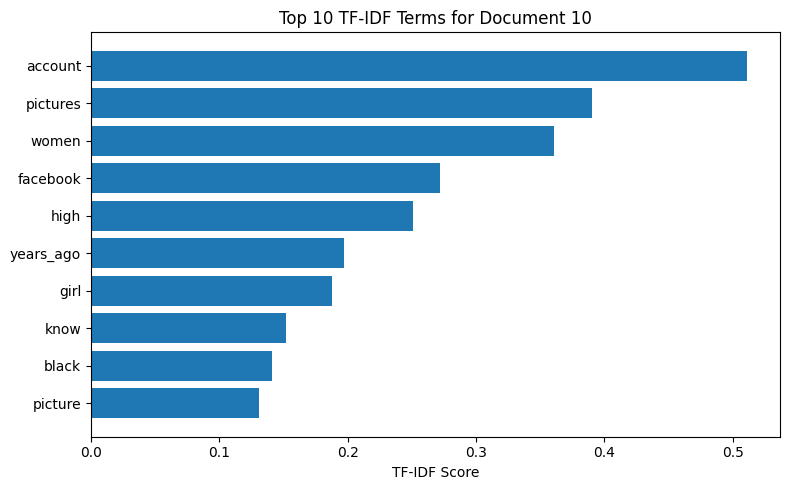

In [36]:
import matplotlib.pyplot as plt

def plot_top_terms(tfidf_vector, feature_names, doc_id=0, top_n=10):
    row = tfidf_vector[doc_id].toarray()[0]
    top_indices = row.argsort()[-top_n:][::-1]
    terms = [feature_names[i] for i in top_indices]
    scores = [row[i] for i in top_indices]

    plt.figure(figsize=(8, 5))
    plt.barh(terms[::-1], scores[::-1])
    plt.title(f"Top {top_n} TF-IDF Terms for Document {doc_id}")
    plt.xlabel("TF-IDF Score")
    plt.tight_layout()
    plt.savefig(f"outputs_lesson/top_terms_doc_{doc_id}.png", dpi=300)
    plt.show()

# Change doc_id below to get data for a different post
plot_top_terms(tfidf, tfidf_vectorizer.get_feature_names_out(), doc_id=10)

## Top Terms Across the Corpus (Mean TF-IDF)

Now, let's move from document-level to corpus-level views:

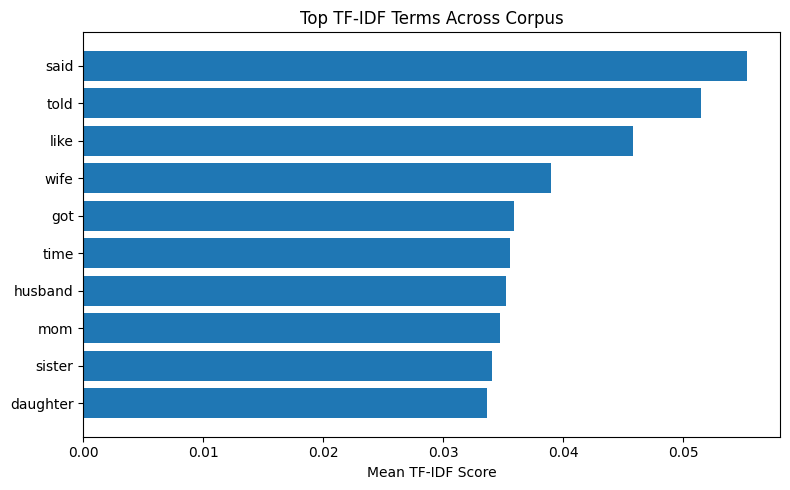

In [37]:
mean_tfidf = tfidf.mean(axis=0).A1
terms = tfidf_vectorizer.get_feature_names_out()
top_indices = mean_tfidf.argsort()[-10:][::-1]

top_terms = [terms[i] for i in top_indices]
top_scores = [mean_tfidf[i] for i in top_indices]

plt.figure(figsize=(8, 5))
plt.barh(top_terms[::-1], top_scores[::-1])
plt.title("Top TF-IDF Terms Across Corpus")
plt.xlabel("Mean TF-IDF Score")
plt.tight_layout()
plt.savefig("outputs_lesson/top_terms_corpus.png", dpi=300)
plt.show()

## 💭 Reflection
- What kinds of words does TF-IDF seem to prioritize, and which does it ignore? Are these terms really the most "important" in a post?  
- How might this weighting reinforce certain biases (e.g. technical terms, rare slang, moral judgments)?  
- What assumptions are we making about what matters in language?

<a id='similar'></a>

## Using TF-IDF to Find Similar Posts

We can use TF-IDF to work out the similarity between any pair of documents. So given one post or comment, we could see which posts or comments are most similar. This can be useful if you're trying to find other examples of a pattern you have found and want to explore further.

Let's choose a particular document, and try and find similar documents.

In [24]:
doc_idx = 25

In [25]:
df['selftext'].iloc[doc_idx]

'It\'s 6PM on a Friday, store has hundreds of people, there are only 3 registers open and lines are ridiculously long. The self checkout has a line that wraps but its the fastest moving line so we wait about 15 minutes in line to check ourselves out.\n\nAfter we check out, a line is forming to exit the building because everyone is waiting for the walmart receipt checker to glance at their receipt.\n\nI\'m already frustrated because of the wait so I skip the line, and the checker anxiously tries to get my attention and loudly says "SIR I NEED TO CHECK YOUR RECEIPT!", I respond with a loud(because its loud in the store) "NO THANK YOU", and walk out of the building.  People start following my example.\n\nThus ensues a 15 minute fight in the car with the wife because she feels I made a scene.\n\nEDIT: Well this turned out well.'

🔔 **Question:** What is this post about?

Let's have a quick look at the TF-IDF scores for the words in this submission to see if these words are indeed typical for this particular submission. 

In [26]:
tfidf_df.loc[doc_idx].sort_values(ascending=False)

line        0.587866
check       0.342692
building    0.283186
loud        0.263129
store       0.251261
              ...   
friends     0.000000
fuck        0.000000
fucking     0.000000
fully       0.000000
youngest    0.000000
Name: 25, Length: 1000, dtype: float64

🔔 **Question:** Do the distinctive words have to do with the topic of the post?

## Calculating similarity 

Now let's find the closest posts to this one. The fact that our documents are now in a vector space allows us to make use of mathematical similarity metrics.

**Cosine similarity** is one metric used to measure how similar the documents are irrespective of their size. Mathematically, it measures the cosine of the angle between two vectors projected in a multi-dimensional space. It is equal to 1 if the documents are the same, and decreases to 0 the more dissimilar they are.

We can use a cosine similarity function from `sklearn` to calculate the cosine similarity between each pair of documents:

In [27]:
from sklearn.metrics.pairwise import cosine_similarity
similarities = cosine_similarity(tfidf)
similarities.shape

(16309, 16309)

We can put the text and scores in a dataframe, and sort by the score:

In [28]:
similar_df = pd.DataFrame({
    'text': df['selftext'].values,
    'score': similarities[doc_idx]}).sort_values('score', ascending=False)

The top document will be the document itself (it's going to have a similarity of 1 with itself). So we look at the next document.

In [29]:
similar_df['text'].iloc[0]

'It\'s 6PM on a Friday, store has hundreds of people, there are only 3 registers open and lines are ridiculously long. The self checkout has a line that wraps but its the fastest moving line so we wait about 15 minutes in line to check ourselves out.\n\nAfter we check out, a line is forming to exit the building because everyone is waiting for the walmart receipt checker to glance at their receipt.\n\nI\'m already frustrated because of the wait so I skip the line, and the checker anxiously tries to get my attention and loudly says "SIR I NEED TO CHECK YOUR RECEIPT!", I respond with a loud(because its loud in the store) "NO THANK YOU", and walk out of the building.  People start following my example.\n\nThus ensues a 15 minute fight in the car with the wife because she feels I made a scene.\n\nEDIT: Well this turned out well.'

In [30]:
similar_df['text'].iloc[1]

'I was in the TSA Precheck line where people are generally cognizant of the regulations. Unfortunately, a woman with her 3 children somehow ended up in this line. I have no patience for people who hold up the TSA screening line. This woman had to fish out all her feeding bottles from her 3 or 4 poorly organized bags and empty them before putting her belongings through security screening. As a result, she held up the security line for a long time. I finally had it and told her she should have been aware of the rules about liquids before getting in line and should have prepared for security screening before getting in line. I suggested that she step aside and let other travelers through and my suggestion was met with a few cheers. \n\nShe seemed really embarrassed but didn’t apologize at all. After I passed the screen I mentioned to the TSA agent he should manage the queue better. When a traveler was holding up the line he needed to step in, and he failed. He apologized and I moved on. I

💭 **Reflection**: Think about why this document seems similar, in terms of TF-IDF scores, to the one we pulled out first. Do you agree with this calculation of similarity? 


## Using TF-IDF to Find Posts

TF-IDF has been used in search algorithms. This makes sense: after all, it can tell you which words are uncommonly frequent in some text. In this sense, TF-IDF can act as a keyword or topic identifier.

For instance, if we would want to look for a text in our DF that has a high TF-IDF score for the word "husband", we could create a **boolean mask** of our `tfidf_df`. Below, we only select those rows where the column "husband" has a TF-IDF score higher than `.5`. We can then use that mask to subset our original `df`! This is because the rows in both DataFrames refer to the same thing: our Reddit posts.

In [31]:
# Subsetting one DF with the mask of another DF
tfidf_husband_df = df[tfidf_df['husband'] > .5]
tfidf_husband_df.head(3)

,idint,idstr,created,self,nsfw,author,title,url,selftext,score,subreddit,distinguish,textlen,num_comments,flair_text,flair_css_class,augmented_at,augmented_count,pp_text
127,625049650,t3_ac4zea,1546515991,1.0,0.0,mmehex,AITA for not wanting my husband’s best friend ...,NaN,My husband and I just got into (another) fight...,9595.0,AmItheAsshole,NaN,6009.0,1272.0,Not the A-hole,not,NaN,NaN,husband got fight best_friend comes wednesday ...
3257,840429408,t3_dwdbhc,1573754856,1.0,1.0,wifeindilemma87,WIBTA if lie to my husband about having a misc...,NaN,I 32(F) and my husband 41(M) have been togethe...,10507.0,AmItheAsshole,NaN,2943.0,729.0,Asshole,ass,NaN,NaN,32(f husband 41(m years married months marriag...
3307,843478036,t3_dy6ntg,1574099693,1.0,0.0,throwaway2340821,AITA for referring to my soon-to-be-ex husband...,NaN,To make this very short:\n\nMy husband and I a...,1584.0,AmItheAsshole,NaN,796.0,533.0,NaN,NaN,NaN,NaN,short husband divorcing husband rampant infide...


We can now get the "selftext" column from this new subsetted DataFrame, and then get the first post just to have a look:

In [32]:
print(tfidf_husband_df['selftext'].iloc[0])

My husband and I just got into (another) fight because his best friend who comes over every Wednesday is (again) staying the night. 

My husband and this friend have had a Wednesday night “date” where the guy comes over to our house to “jam” every week for the last two years, and I’m getting to the point that I want to hit the guy over the head with whatever is closest at hand every time he is around. 

Buckle up. This is probably going to be a long one.... if you make it through all of this you are my hero. 

At first he was supposed to come over just for a few hours on Wednesday nights to play guitar with my husband while I was at work. Over time I have stopped working late Wednesday’s but the jam session continues. Which was fine. However, for the last year they have barely touched the guitars and instead the guy just comes over to get high (on pot). Neither my husband or I get high with him (I don’t enjoy pot and my husband isn’t much into it either, but we aren’t morally against i

## Using TF-IDF Correlations to Explore Biases

Calculating correlations of TF-IDF values can be a useful technique to explore relationships between words or terms in a corpus. By analyzing the correlations, we can identify whether certain words tend to appear together more frequently or if they are related to similar topics. 

Pandas allows us to trace pairwise correlations in a DataFrame using the `corr()` method. Note that this creates a new DataFrame that is square and symmetric. Each element in the resulting DataFrame represents the correlation coefficient between all terms.

In [33]:
corr = tfidf_df.corr()

In [34]:
corr

,000,50,able,absolutely,accept,accepted,accident,account,accused,act,...,year_old,years,years_ago,yelled,yelling,yes,yesterday,young,younger,youngest
000,1.000000,0.014139,0.036475,0.000376,0.005415,0.008532,0.028235,0.027598,-0.003036,-0.008888,...,-0.012713,0.040823,0.022769,-0.009040,-0.017525,-0.017921,-0.009782,0.007396,-0.002258,-0.001421
50,0.014139,1.000000,0.016804,0.007208,-0.006667,-0.009091,-0.005264,0.011248,0.001359,-0.006908,...,-0.007804,0.023646,0.009085,-0.007105,-0.007972,-0.009559,-0.015982,-0.014583,-0.015530,-0.008740
able,0.036475,0.016804,1.000000,0.005642,0.013888,0.015186,0.006861,0.017453,0.002895,-0.004364,...,0.001201,0.039702,0.007140,-0.020331,-0.011594,-0.007160,-0.017079,-0.009815,0.005187,0.006926
absolutely,0.000376,0.007208,0.005642,1.000000,0.008280,-0.000671,0.001131,-0.010034,0.011936,0.008922,...,0.003651,0.024452,-0.009812,0.004214,0.000843,0.005773,0.001515,0.003721,-0.002574,-0.004474
accept,0.005415,-0.006667,0.013888,0.008280,1.000000,0.047515,-0.002697,0.003283,0.018430,-0.006442,...,-0.000110,0.025289,0.023666,0.000736,-0.010417,0.004104,-0.000736,0.005091,0.009769,0.013860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yes,-0.017921,-0.009559,-0.007160,0.005773,0.004104,-0.009346,-0.005113,-0.001278,0.005524,0.001917,...,-0.009585,0.002038,-0.004933,-0.000462,0.005944,1.000000,0.014751,-0.011600,0.001518,0.002262
yesterday,-0.009782,-0.015982,-0.017079,0.001515,-0.000736,-0.002653,-0.001848,-0.000596,-0.004242,0.018321,...,-0.007833,-0.042490,-0.021834,0.035170,0.019965,0.014751,1.000000,-0.013810,-0.013943,-0.010387
young,0.007396,-0.014583,-0.009815,0.003721,0.005091,0.011985,-0.007155,0.000461,-0.002715,0.007255,...,0.038290,0.022121,0.011046,-0.010074,-0.007828,-0.011600,-0.013810,1.000000,0.049780,0.027628
younger,-0.002258,-0.015530,0.005187,-0.002574,0.009769,0.031633,0.005502,-0.011641,0.025247,-0.006545,...,0.033990,0.050015,0.028493,0.001985,-0.005472,0.001518,-0.013943,0.049780,1.000000,0.070817


We can use this new DataFrame to compare two concepts in our data. We will look for the columns of "husband" and "wife" – two concepts we expect to appear in this dataset, and that we could imagine being related to gender bias. We then sort the values of the resulting DataFrame based on the "wife" columns in descending order, and print the first 20 values. 

These will be the top-20 words that are most strongly correlated to the term "wife". 

In [35]:
corr[['husband','wife']].sort_values(by='wife',ascending=False)[:30]

,husband,wife
wife,-0.079207,1.000000
daughter,0.070411,0.171265
married,0.137731,0.107447
son,0.117059,0.091934
daughters,0.053718,0.089414
divorce,0.044386,0.073840
kids,0.101608,0.070027
marriage,0.077340,0.064245
home,0.060662,0.060368
ex,0.025977,0.057284


## 💭 Reflection: 

- Do these related terms make sense? 
- Do you see some terms that could be indicative of a bias towards women in the data? 
- What happens if you change the `by=` sortation to `men`? What words appear now, and how do they make sense?

<div class="alert alert-success">

## ❗ Key Points

* Term Frequency, or TF, reflects how often a unique token appears in a corpus.
* Inverse Document Frequency (IDF) reflects the number of documents in the corpus that contain a term. 
* The TF-IDF score of a word reflects how important that word is to a document in a collection or corpus.
* Methods from `scikit-learn` can be used to generate TF and TF-IDF scores for a given corpus.
* TF-IDF scores can be used to calculate how similar documents are. We can do this with mathematical similarity metrics, such as cosine similarity.
    
</div>